# Fixing Keck Telescope offset

In [7]:
#Importing and notebook setup
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize
from gatspy.periodic import LombScargleFast

#for Radvel
import matplotlib
import pylab as pl
res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )
#Get residuals
#orbel = []
#radvel.kepler.rv_drive(t)
plot_results(like)             # plot best fit model
print post
radvel.plotting.rv_multipanel_plot(post, epoch=2440000)
import corner

import radvel
import radvel.plotting

matplotlib.rcParams['font.size'] = 14

Importing Data

In [31]:
#Data import
data= pd.read_csv('C:/users/rscsa/Research/radvel-master/research/HD75732/HD75732.csv')
# data_rk = data[0:23]
# data_rj = data[24:653]
data.mnvel[0:23] = data.mnvel[0:23]+25

# data = data_rk + data_rj
#Naming Variables from data
t = np.array(data_rj.jd)
vel = np.array(data_rj.mnvel)
errvel = np.array(data_rj.errvel)

#best fit time vector
ti = np.linspace(t.min(),t.max(),num=len(t)* 10000)
# print data

C:\Users\rscsa\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [20]:
def periodogram(datax, datay, min_, max_, nyquist):
    model = LombScargleFast().fit(datax, datay)
    period, power = model.periodogram_auto(nyquist_factor=nyquist) # Default 50

    #Plotting
    plt.figure
    plt.plot(period,power)
    plt.ylabel('Power')
    plt.xlabel('Period')# days
    plt.xscale('log')
#     plt.xlim(min_-1,max_+10)

    # set range and find period (Correct)
    model.optimizer.period_range=(min_, max_)
    period = model.best_period
    print("period = {0}".format(period))
    return period

In [21]:
def RMS (Residuals):
    RMS = np.sqrt(sum(Residuals**2 / (len(Residuals))))
    return RMS

In [22]:
def residuals(data_x, data_y,amplitude,period,phase_shift,vertical_shift):
    # Target function
    fitfunc = lambda p, x: p[0]*np.cos(2*np.pi/p[1]*x+p[2]) + p[3]*x
    #Distance to the target function
    errfunc = lambda p, x, y: fitfunc(p, x) - y 
    
    # Initial guess for the first set's parameters
    p0 = [amplitude, period, phase_shift, vertical_shift]
    p1, success = optimize.leastsq(errfunc, p0[:], args=(data_x, data_y))
    
    print 'Amplitude: ', p1[0]
    print 'Period: ', p1[1]
    print 'Phase Shift: ', p1[2]
    print 'Vertical-Shift: ',p1[3]
    period = p1[1]
    
    #Finding Residuals
    Residuals = data_y - fitfunc(p1,data_x)
    #Finding RMS
    RMS = np.sqrt(sum(Residuals**2 / (len(Residuals))))
    #chisquared
    #chisquared = sum(Residuals**2/(fitfunc(p1,data_x)))
    print "RMS of Residuals: ", RMS
    #print "Chi-Squared for Residuals: ", chisquared
    
    #Plotting Data with Fit
    time = np.linspace(data_x.min(), data_x.max(), 1000*len(data_x))
    plt.plot(data_x, data_y, "go", time, fitfunc(p1, time),"b-")
    plt.title('HD217014')
    plt.xlabel('Time [JD-2.44e6]')
    plt.ylabel('Mean Velocity[m/s]')
    plt.legend(('Data', 'Fit'))
    plt.xlim(data_x[0]-5,data_x[-1]+5)
    ax1 = plt.axes()
    plt.show()
    
    #plotting Residuals
    #plt.plot(data_x, Residuals, "ro", time, fitfunc(p2, time),"b-")
    plt.plot(data_x, Residuals, "ro")
    plt.xlim(data_x[0]-5,data_x[-1]+5)
    plt.ylim(-max(data_y)-10, max(data_y)+10)
    plt.title('Residuals')
    plt.xlabel('Time [JD-2.44e6]')
    plt.ylabel('Mean Velocity[m/s]')
    plt.legend(('Residuals', 'Fit'))
    ax2 = plt.axes()
    
    return Residuals, period

In [23]:
def plot_results(like):
    fig = pl.figure(figsize=(12,4))
    fig = pl.gcf()
    pl.errorbar(
        like.x, like.model(t)+like.residuals(), 
        yerr=like.yerr, fmt='o'
        )
    pl.plot(ti, like.model(ti))
    fig.set_tight_layout(True)
    pl.xlabel('Time')
    pl.ylabel('RV')
    pl.draw()

Finding optimal frequency:
 - Estimated peak width = 0.00142
 - Using 5 steps per peak; omega_step = 0.000284
 - User-specified period range:  1 to 4.4e+03
 - Computing periods at 22126 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 14.6521574048


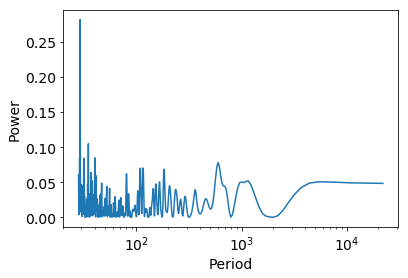

In [24]:
nyquist = .5
period1 = periodogram(t,vel,1,max(t)-min(t),nyquist)

In [25]:
nplanets = 1
# instnames = ['k', 'j']    # list of instrument names. Can be whatever you like but should match 'tel' column in the input file.
# ntels = len(instnames)       # number of instruments with unique velocity zero-points

def initialize_model():
    time_base = 2420
    params = radvel.RVParameters(nplanets,basis='per tc secosw sesinw logk')
    
    #1st Planet
    params['per1'] = period1    # period of 1st planet
    params['tc1'] = 2074.52   # time of inferior conjunction of 1st planet
    params['secosw1'] = 0.01 
    params['sesinw1'] =  0.01 
    params['logk1'] =  np.log(50)   # velocity semi-amplitude for 1st planet  
    

    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = 0.0         # slope
    mod.params['curv'] = 0.0        # curvature  
    return mod

In [26]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
like.params['gamma'] = 1.0
like.params['jit'] = 2.6
# like.params['gamma_k'] = 0.0
# like.params['gamma_j'] = 1.0
# like.params['jit_k'] = 2.6
# like.params['jit_j'] = 2.6

In [27]:
like.vary['curv'] = True
like.vary['dvdt'] = True
#like.vary['per1'] = False
#like.vary['logk1'] = False
#like.vary['secosw1'] = False
#like.vary['sesinw1'] = False
#like.vary['tc1'] = False


C:\Users\rscsa\Anaconda2\lib\site-packages\matplotlib\figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


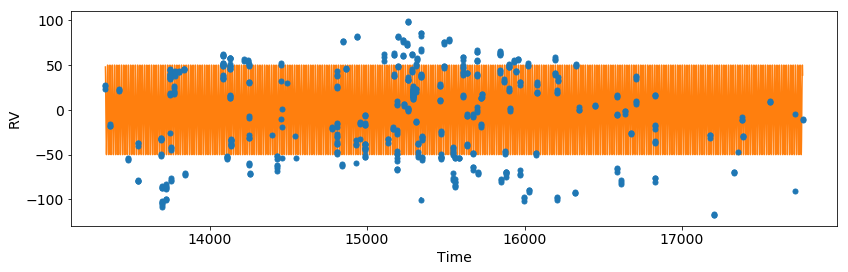

In [28]:
pl.figure()
plot_results(like)
# radvel.plotting.rv_multipanel_plot(post, epoch=2440000)

In [29]:
post = radvel.posterior.Posterior(like)

post.priors += [radvel.prior.Gaussian('per1',like.params['per1'],.25*like.params['per1'])]

post.priors += [radvel.prior.EccentricityPrior(nplanets)] #change for # of planets
post.priors += [radvel.prior.PositiveKPrior( nplanets )]

post.priors += [radvel.prior.Gaussian( 'jit', np.log(1), np.log(15))]
#post.priors += [radvel.prior.Gaussian( 'jit_k', np.log(1), np.log(15))]
#post.priors += [radvel.prior.Gaussian( 'jit_j', np.log(1), np.log(15))]

print post

parameter                     value      vary
per1                        14.6522       True
tc1                         2074.52       True
secosw1                        0.01       True
sesinw1                        0.01       True
logk1                       3.91202       True
dvdt                              0       True
curv                              0       True
jit                             2.6       True
gamma                             1       True

Priors
------
Gaussian prior on per1, mu=14.6521574048, sigma=3.66303935119
e1 constrained to be < 0.99
K constrained to be > 0
Gaussian prior on jit, mu=0.0, sigma=2.7080502011



parameter                     value      vary
per1                        14.6518       True
tc1                         2074.48       True
secosw1                   0.0798337       True
sesinw1                  -0.0809386       True
logk1                       4.17498       True
dvdt                   -0.000776938       True
curv                   -7.16438e-09       True
jit                         21.3251       True
gamma                       2.72031       True

Priors
------
Gaussian prior on per1, mu=14.6521574048, sigma=3.66303935119
e1 constrained to be < 0.99
K constrained to be > 0
Gaussian prior on jit, mu=0.0, sigma=2.7080502011



C:\Users\rscsa\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


(<matplotlib.figure.Figure at 0xf0b3dd8>,
  <matplotlib.axes._subplots.AxesSubplot at 0xfdf12e8>])

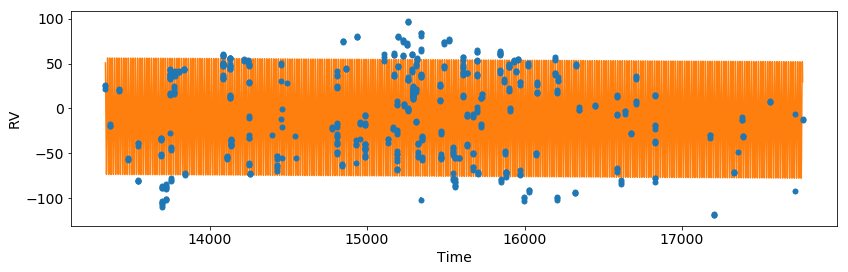

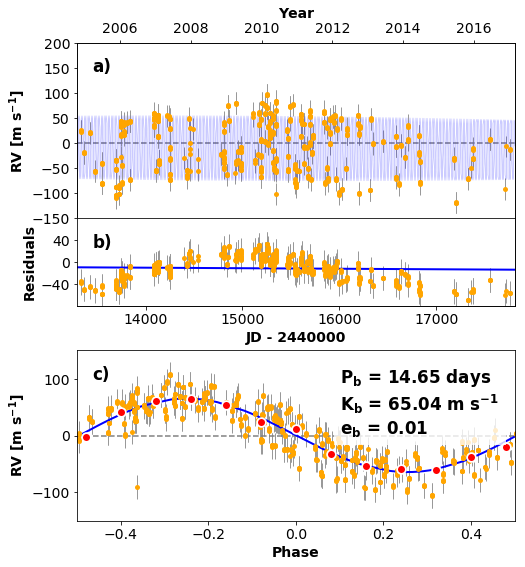

In [30]:
res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )
#Get residuals
#orbel = []
#radvel.kepler.rv_drive(t)
plot_results(like)             # plot best fit model
print post
radvel.plotting.rv_multipanel_plot(post, epoch=2440000)